In [1]:
%matplotlib inline
import os

import numpy as np
import xarray as xr

import esmlab
import pop_tools

import ncar_jobqueue
from dask.distributed import Client

import utils
import climo_utils as cu
import ann_avg_utils as aau
units, _ = aau.get_pint_units()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs
import cmocean

import xpersist as xp
# Set up xperist cache
cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache', 'chl')
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/pooch/core.py:185: UserWarning: Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.
  warn(message)


cartopy       0.17.0
xpersist      2020.4.30
esmlab        2019.4.27.post55
ncar_jobqueue 2020.3.4
cmocean       2.0
numpy         1.18.4
xarray        0.15.1
pop_tools     0.0.post167
Mike Levy 2020-05-08 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper05
Git hash   : 55a1bf6f2253e1b46c393bb44fcd3a3cce9ec211


In [2]:
try:
    cluster
    client
except: 
    cluster = ncar_jobqueue.NCARCluster(project='P93300606')
    cluster.adapt(minimum_jobs=0, maximum_jobs=24)
    client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.14:45569 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
%%time

def _compute_ds_surf():
    PFTs = ['sp', 'diat', 'diaz']
    for n, PFT in enumerate(PFTs):
        # Read CESM data
        variable = f'{PFT}Chl'
        ds_tmp = cu.read_CESM_var(slice("1990-01-15", "2015-01-15"), variable, mean_dims='member_id').isel(z_t_150m=0) # 1990 - 2014, inclusive
        if n == 0:
            ds_surf = ds_tmp.rename({variable : 'totChl'})
        else:
            ds_surf['totChl'] = ds_surf['totChl'] + ds_tmp.rename({variable : 'totChl'})['totChl']
        del(ds_tmp)
    ds_surf['totChl'].attrs['long_name'] = 'Total Chlorophyll at Surface'
    return ds_surf

xp_func = xp.persist_ds(_compute_ds_surf, name=f'totChl_monthly', trust_cache=True)
ds_surf = xp_func()

ds_surf_avg = ds_surf.mean(dim='time') # unweighted (should be weighted by days per month)
da_surf_avg = ds_surf_avg['totChl']

ds_ann = ds_surf.drop(['dz', 'z_t']).groupby('time.month').mean()
ds_ann = ds_ann.assign_coords(month=np.arange(12, dtype=np.int32))
ds_ann['month'].encoding['dtype'] = np.int32
ds_ann['month'].attrs['_FillValue'] = np.int32(-100)

ds_DJF = ds_surf.drop(['dz', 'z_t']).groupby('time.month').mean()
ds_DJF = ds_DJF.assign_coords(month= np.arange(12, dtype=np.int32))
ds_DJF['month'].encoding['dtype'] = np.int32
ds_DJF['month'].attrs['_FillValue'] = np.int32(-100)

ds_JJA = ds_surf.drop(['dz', 'z_t']).groupby('time.month').mean()
ds_JJA = ds_JJA.assign_coords(month=np.arange(12, dtype=np.int32))
ds_JJA['month'].encoding['dtype'] = np.int32
ds_JJA['month'].attrs['_FillValue'] = np.int32(-100)

try:
    del(tot_days_ann)
except:
    pass
try:
    del(tot_days_DJF)
except:
    pass
try:
    del(tot_days_JJA)
except:
    pass
for n, days in enumerate([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]):
    # Annual
    try:
        tot_days_ann = tot_days_ann + days
        ds_surf_ann_avg = ds_surf_ann_avg + ds_ann.isel(month=n, drop=True) * days
    except:
        tot_days_ann = days
        ds_surf_ann_avg = ds_ann.isel(month=n, drop=True) * days
    # DJF
    if n in [0, 1, 11]:
        try:
            tot_days_DJF = tot_days_DJF + days
            ds_surf_DJF_avg = ds_surf_DJF_avg + ds_DJF.isel(month=n, drop=True) * days
        except:
            tot_days_DJF = days
            ds_surf_DJF_avg = ds_DJF.isel(month=n, drop=True) * days
    # JJA
    if n in [5, 6, 7]:
        try:
            tot_days_JJA = tot_days_JJA + days
            ds_surf_JJA_avg = ds_surf_JJA_avg + ds_JJA.isel(month=n, drop=True) * days
        except:
            tot_days_JJA = days
            ds_surf_JJA_avg = ds_JJA.isel(month=n, drop=True) * days

print(f'{tot_days_ann} days in a year')
da_surf_ann_avg = ds_surf_ann_avg['totChl']/tot_days_ann

print(f'{tot_days_DJF} days in DJF')
da_surf_DJF_avg = ds_surf_DJF_avg['totChl']/tot_days_DJF

print(f'{tot_days_JJA} days in JJA')
da_surf_JJA_avg = ds_surf_JJA_avg['totChl']/tot_days_JJA



assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/chl/totChl_monthly.nc


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


365 days in a year
90 days in DJF
92 days in JJA
CPU times: user 2.83 s, sys: 1.6 s, total: 4.44 s
Wall time: 6.13 s


In [4]:
ds_surf_obs_ann = cu.read_obs(src='SeaWiFS', freq='ann')['chl_gsm'].to_dataset(name='totChl')
ds_surf_obs_DJF = cu.read_obs(src='SeaWiFS', freq='DJF')['chl_gsm'].to_dataset(name='totChl')
ds_surf_obs_JJA = cu.read_obs(src='SeaWiFS', freq='JJA')['chl_gsm'].to_dataset(name='totChl')

In [5]:
ds_surf_plot = xr.Dataset({
    'totChl_DJF': da_surf_DJF_avg, 
    'totChl_JJA': da_surf_JJA_avg, 
    'totChl_DJF_obs': ds_surf_obs_DJF['totChl'].drop(['TLONG', 'TLAT']), 
    'totChl_JJA_obs': ds_surf_obs_JJA['totChl'].drop(['TLONG', 'TLAT']),     
})
ds_surf_plot = utils.pop_add_cyclic(ds_surf_plot)
ds_surf_plot.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;

variables:
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 totChl_DJF(nlat, nlon) ;
		totChl_DJF:long_name = Total Chlorophyll at Surface ;
		totChl_DJF:units = mg/m^3 ;
		totChl_DJF:grid_loc = 3114 ;
		totChl_DJF:cell_methods = time: mean ;
	float32 totChl_JJA(nlat, nlon) ;
		totChl_JJA:long_name = Total Chlorophyll at Surface ;
		totChl_JJA:units = mg/m^3 ;
		totChl_JJA:grid_loc = 3114 ;
		totChl_JJA:cell_methods = time: mean ;
	float64 totChl_DJF_obs(nlat, nlon) ;
		totChl_DJF_obs:long_name = Chlorophyll Concentration, GSM model ;
		totChl_DJF_obs:units = mg m^-3 ;
		totChl_DJF_obs:standard_name = mass_concentration_chlorophyll_concentration_in_sea_water ;
		totChl_DJF_obs:reference = Maritorena S., D.A. Siegel and A. Peterson, Optimization of a Semi-Analytical Ocean Color Model for Global Scale Applications, Applied  Optics,  41(15): 2705-2714, 2002. ;
		totChl_DJF_obs:display_scale = log ;
		totChl_DJF_obs

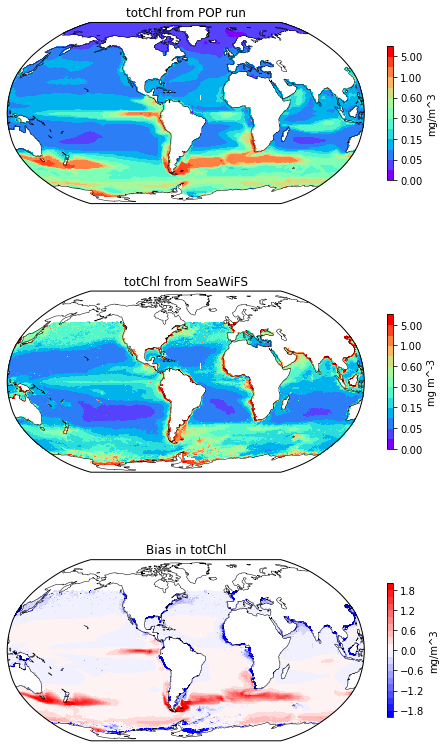

In [6]:
cu.plot_surface_vals('totChl', ds_surf_DJF_avg, da_surf_DJF_avg, ds_surf_obs_DJF['totChl'], obs_src='SeaWiFS',
                     levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20],
                     bias_levels=np.linspace(-2, 2, 21))

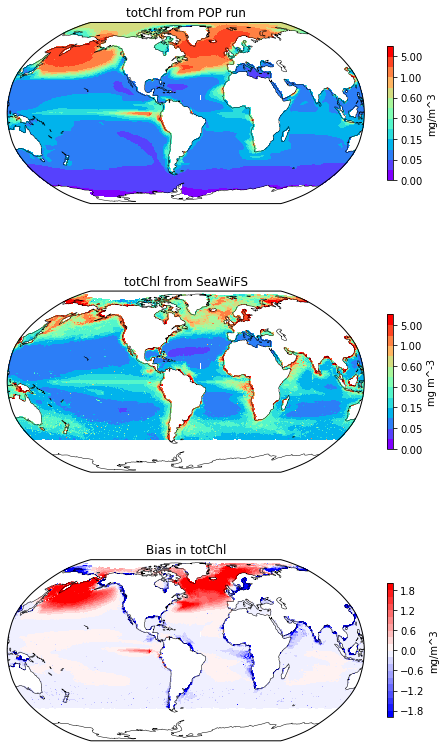

In [7]:
cu.plot_surface_vals('totChl', ds_surf_JJA_avg, da_surf_JJA_avg, ds_surf_obs_JJA['totChl'], obs_src='SeaWiFS',
                     levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20],
                     bias_levels=np.linspace(-2, 2, 21))

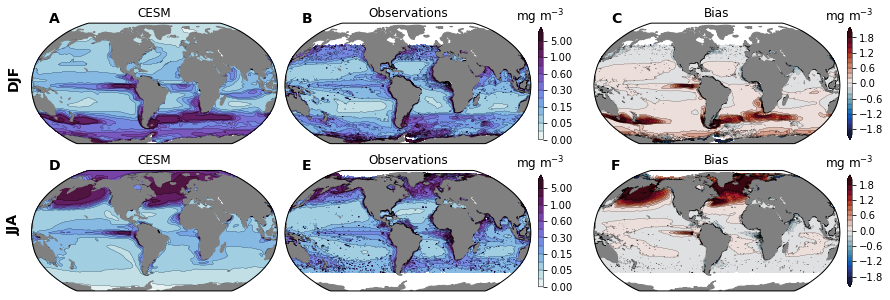

In [8]:
units = 'mg m$^{-3}$'
title = {
    'totChl_DJF': 'Chlorophyll (DJF)', 
    'totChl_JJA': 'Chlorophyll (JJA)',     
}

cmap_field = cmocean.cm.dense
cmap_bias = cmocean.cm.balance

levels = dict(
    totChl=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20],
)

levels_bias = dict(
    totChl=np.linspace(-2, 2, 21),
)    


contour_spec = dict(
    totChl=dict(
        levels=levels['totChl'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['totChl'], ncolors=cmap_field.N),
    ),
    totChl_bias=dict(
        levels=levels_bias['totChl'], 
        extend='both',        
        cmap=cmap_bias,
        norm=colors.BoundaryNorm(levels_bias['totChl'], ncolors=cmap_bias.N),        
    ),
)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 0.02, 1, 0.02))

prj = ccrs.Robinson(central_longitude=305.0)

axs = []
maps = []
for i, fld in enumerate(['totChl_DJF', 'totChl_JJA']):
    ax_m = plt.subplot(gs[i, 0], projection=prj)
    ax_o = plt.subplot(gs[i, 1], projection=prj)
    ax_b = plt.subplot(gs[i, 3], projection=prj)
    
    cax_field = plt.subplot(gs[i, 2])
    cax_bias = plt.subplot(gs[i, 4])
    
    axs.append((ax_m, ax_o, cax_field, ax_b, cax_bias))
    maps.extend([ax_m, ax_o, ax_b])
    
    cesm = ds_surf_plot[fld]
    obs = ds_surf_plot[f'{fld}_obs']
    bias = cesm - obs

    cf_m = ax_m.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
        **contour_spec['totChl'],        
        transform=ccrs.PlateCarree(),
    )
    
    cl_m = ax_m.contour(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
        levels=contour_spec['totChl']['levels'], colors='k', linewidths=0.2,
        transform=ccrs.PlateCarree(),        
    )
    
    cf_o = ax_o.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
        **contour_spec['totChl'],        
        transform=ccrs.PlateCarree(),        
    )

    cl_o = ax_o.contour(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
        levels=contour_spec['totChl']['levels'], colors='k', linewidths=0.2,
        transform=ccrs.PlateCarree(),        
    )
    
    cf_b = ax_b.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
        **contour_spec['totChl_bias'],                     
        transform=ccrs.PlateCarree(),        
    )    

    cl_b = ax_b.contour(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
        levels=contour_spec['totChl_bias']['levels'], colors='k', linewidths=0.2,
        transform=ccrs.PlateCarree(),        
    )
    
    for ax in [ax_m, ax_o, ax_b]:
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )        
        
    ax_m.set_title('CESM')
    ax_o.set_title('Observations')    
    ax_b.set_title('Bias')        
    
    cb_field = plt.colorbar(cf_o, cax=cax_field, drawedges=True)
    cb_field.ax.set_title(units)
    cb_field.outline.set_linewidth(0.5)
    cb_field.dividers.set_linewidth(0.25)    
    
    cb_bias = plt.colorbar(cf_b, cax=cax_bias, drawedges=True)
    cb_bias.ax.set_title(units)
    cb_bias.outline.set_linewidth(0.5)
    cb_bias.dividers.set_linewidth(0.25)    
    
# add a gap between left two columns and right; scale colorbars
gs.update(left=0.05, right=0.95, hspace=0.05, wspace=0.05)
offset = 0.05
cax_vert_shrink = 0.8
for i in range(len(axs)):
    
    # the row of axis objects
    ax_m, ax_o, cax_field, ax_b, cax_bias = axs[i]
    
    # shift map
    p0 = ax_b.get_position()
    ax_b.set_position([p0.x0 + offset, p0.y0, p0.width, p0.height])

    # shift and scale colorbar
    p0 = cax_bias.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_bias.set_position([p0.x0 + offset, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

    # scale colorbar    
    p0 = cax_field.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_field.set_position([p0.x0, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])


fig.text(0.03, 0.75, 'DJF',
         fontsize=14.,
         fontweight='semibold',
         horizontalalignment='center',
         rotation=90);

fig.text(0.03, 0.5, 'JJA',
         fontsize=14.,
         fontweight='semibold',
         horizontalalignment='center',         
         rotation=90);    
    
utils.label_plots(fig, maps, xoff=0.02, yoff=0)   
utils.savefig('chl-surface-maps.pdf')

## Hovmöller plots for zonal means in Atlantic and Pacific

x-axis should be latitude, y axis should be time (`month`?)

In [9]:
mask3d = pop_tools.region_mask_3d('POP_gx1v7', mask_name='Pacific-Indian-Atlantic')
basins = mask3d.region
nregion = len(mask3d.region)
mask2d = xr.full_like(mask3d.isel(region=0), fill_value=0, dtype=np.int32)
for i in range(1, nregion): # skip first index because "za" puts the global field in there
    mask2d = xr.where(mask3d.isel(region=i)==1, i, mask2d)
mask2d.name = 'REGION_MASK'

In [10]:
ds_obs_ann = cu.read_obs(src='SeaWiFS', freq='monthly')['chl_gsm'].to_dataset(name='totChl')

# recast 'month' as integers to allow introduction of _FillValue
# (kludge for the zonal mean executable)
ds_obs_ann = ds_obs_ann.assign_coords(month=np.arange(12, dtype=np.int32))
ds_obs_ann['month'].encoding['dtype'] = np.int32
ds_obs_ann['month'].attrs['_FillValue'] = np.int32(-100)

In [11]:
kwargs = dict(grid='POP_gx1v7', region_mask=mask2d)

regions = dict()
regions['Pacific Ocean'] = 1
regions['Atlantic Ocean'] = 3

da_zonal_mean = utils.zonal_mean_via_fortran(ds_ann, 'totChl', **kwargs)
da_zonal_mean_obs = utils.zonal_mean_via_fortran(ds_obs_ann, 'totChl', **kwargs)

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output


In [12]:
def hovmoller_plots(da_zonal_mean, da_zonal_mean_obs, region):
    import matplotlib.pyplot as plt
#     import cartopy
#     import cartopy.crs as ccrs

    levels=[0, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    bias_levels = [-4, -3, -2.5, -2, -1.5, -1, -0.75, -0.5, -0.35, -0.2, -0.1, 0, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
    fig = plt.figure(figsize=(8, 17))
    ax = plt.subplot(3, 1, 1)
    subfig = da_zonal_mean.isel(basins=regions[region]).totChl.plot(levels=levels, extend='max')
    ax.set_title(f'{region} from POP run')
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.linspace(-90, 90, 19))
    ax.set_xticklabels('')

    ax = plt.subplot(3, 1, 2)
    da_zonal_mean_obs.isel(basins=regions[region]).totChl.plot(levels=levels, extend='max')
    ax.set_title(f'{region} from SeaWiFS')
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.linspace(-90, 90, 19))
    ax.set_xticklabels('')

    ax = plt.subplot(3, 1, 3)
    (da_zonal_mean - da_zonal_mean_obs).isel(basins=regions[region]).totChl.plot(levels=bias_levels, extend='neither')
    ax.set_title(f'Bias')
    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel('')
    ax.set_xticks(np.linspace(-90, 90, 19))
    # For bottom panel, set up tick labels at -90, -60, -30, 0, 30, 60, and 90
    xticklabels = list(np.linspace(-90, 90, 7, dtype='int'))
    for i in range(18):
        if i%3:
            xticklabels.insert(i, '')

    ax.set_xticklabels(xticklabels)



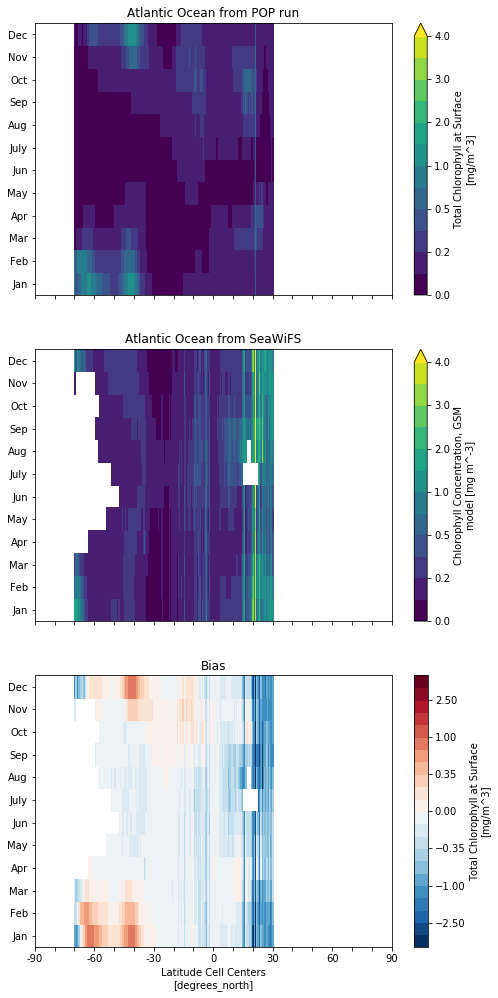

In [13]:
hovmoller_plots(da_zonal_mean, da_zonal_mean_obs, 'Atlantic Ocean')

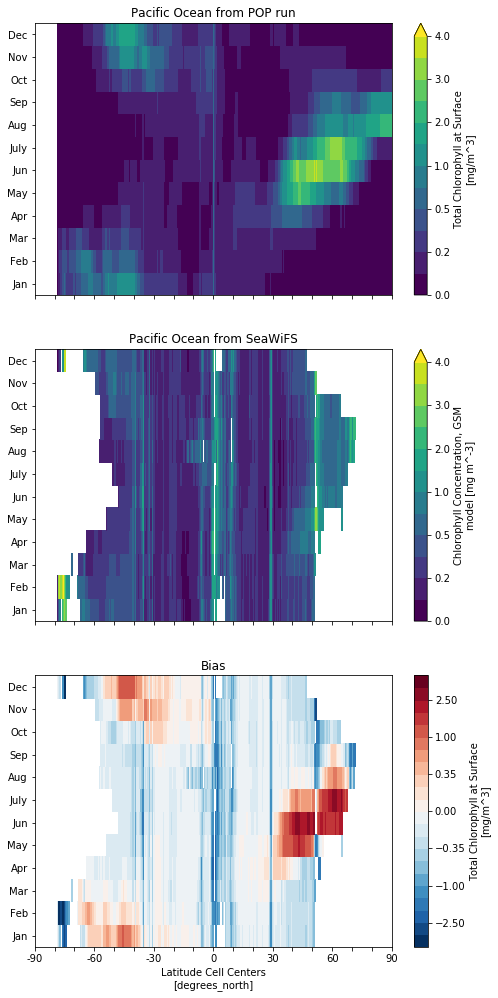

In [14]:
hovmoller_plots(da_zonal_mean, da_zonal_mean_obs, 'Pacific Ocean')